# KEEP THIS FILE UPDATED ON GITHUB IF YOU DID ANY CHANGE !!!!!

 # RL bitcoin trader

 In this notebook I'll use DQN to trade bincoin. The dataset using kaggle in blow.

 https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

In [ ]:
# Download the data
# This cell have to exeucate twice in order to save it into path:/kaggle/input/bitcoin-historical-data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/bitcoin-historical-data


In [ ]:
#Import area
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense
import os

# 1.Data cleaning

This data contain all of bitcoin price in history(from 2012). Recorded every 60 secouds. Denoted by Unix time.

Since Bitcoin at begining is basicily nothing changed. Secoud, Global politics is complex, The price will be change by it (eg. Trump 2024 elected).

There're two solutions:
1.  If price totel change during 5 min is not change more then 5 dollar. will denoted by empty. otherwise keep it.

2. If price totel change totel change. price go up more then 30% itself within a week. will be denoted by empty

## Why we need a dataset for DQNAgnet:
The Data contain bitcoin price in history, I treat those pricies as "State" element in environment. which given to agent.

## Mindset of data missed data for RL agent:
After cleaning Data there are alot of slot missed with price. at each episodes i'll randomily choice random area as given sigma(State). $\sum_{t=0}^{k} S_t$

remeber turn df into 2d array.

In [ ]:
# execute if your working on colab, ignore otherwise
!cd /kaggle/input
!cmode 777 btcusd_1-min_data.csv
!ls -al

/bin/bash: line 1: cmode: command not found
total 132
drwxr-xr-x 1 root root   4096 May  5 17:06 .
drwxr-xr-x 1 root root   4096 May  5 16:45 ..
-rw-r--r-- 1 root root 117536 May  5 19:09 Cleaned-btcusd_1-min_data.csv
drwxr-xr-x 4 root root   4096 May  2 13:33 .config
drwxr-xr-x 1 root root   4096 May  2 13:33 sample_data


In [ ]:
try:
    df = pd.read_csv('/kaggle/input/bitcoin-historical-data/btcusd_1-min_data.csv')
except:
    df = pd.read_csv('Cleaned-btcusd_1-min_data.csv')

In [ ]:
#Not going to use too early data #4000000
df = df[5000000:5002001]

<ipython-input-6-ebc5c56b5cc2>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


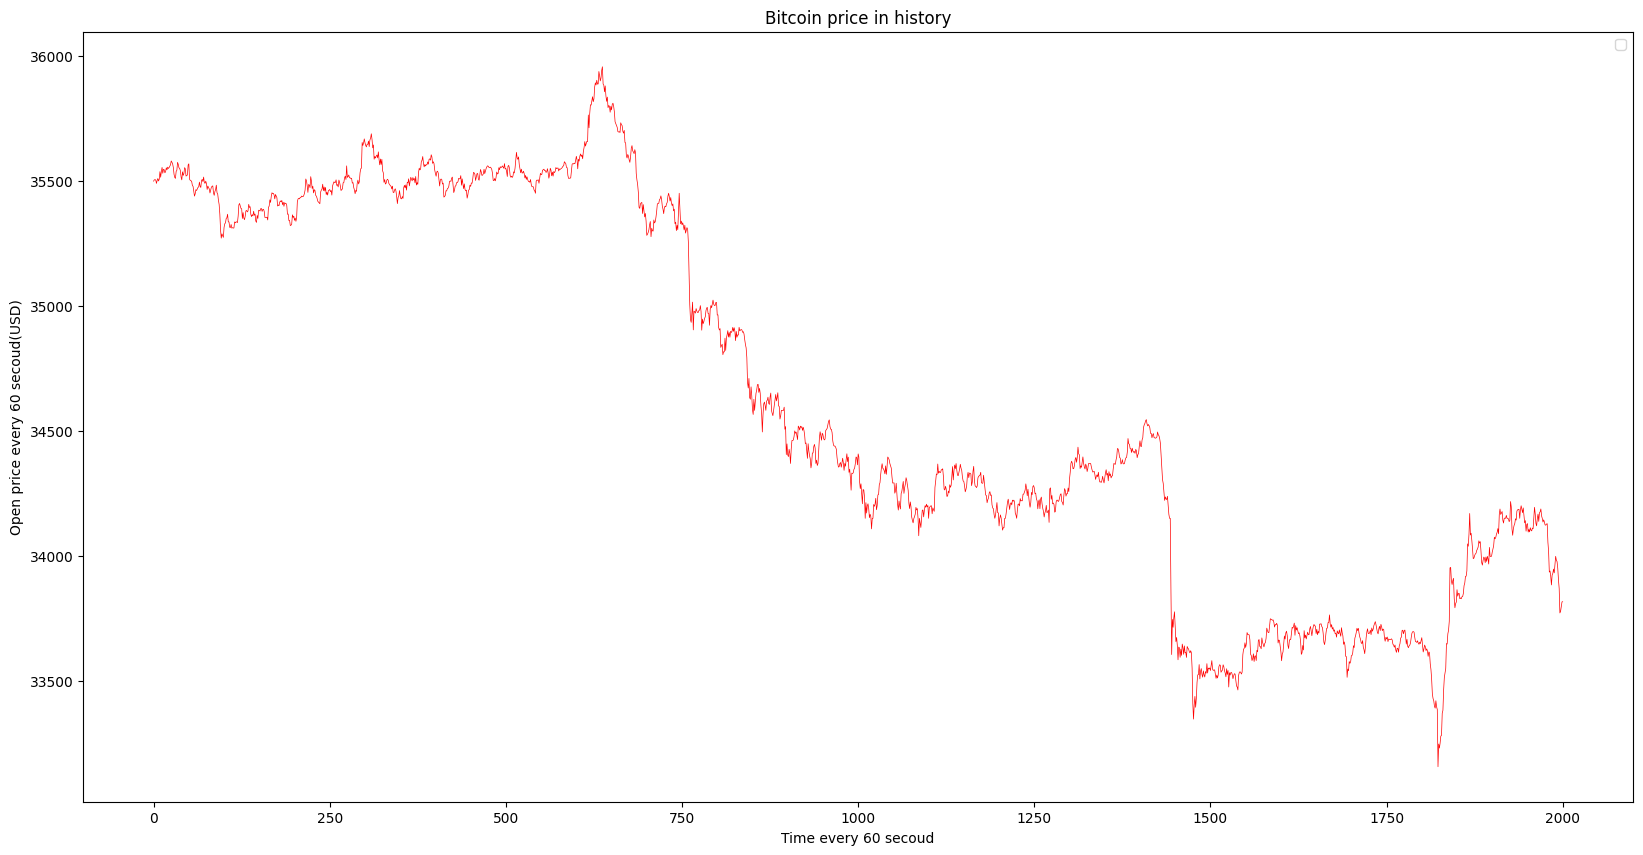

In [ ]:
plt.figure(figsize=(20,10))
plt.plot([x for x in range(df['Open'].shape[0])], df['Open'], color = 'red', linewidth = 0.5)
plt.title("Bitcoin price in history")
plt.xlabel("Time every 60 secoud")
plt.ylabel("Open price every 60 secoud(USD)")
plt.legend();

In [ ]:
df.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [ ]:
df.head(3),
df.tail(3),
df.shape

(2001, 6)

In [ ]:
df.head()

,Timestamp,Open,High,Low,Close,Volume
5000000,1.625412e+09,35500.00,35504.92,35479.83,35494.02,0.134752
5000001,1.625412e+09,35505.61,35505.61,35492.96,35492.96,0.042302
5000002,1.625412e+09,35505.71,35506.81,35505.71,35506.81,0.033886
5000003,1.625412e+09,35505.41,35505.41,35486.62,35486.62,0.041548
5000004,1.625412e+09,35490.91,35506.08,35483.90,35506.08,0.558317


In [ ]:
#Solution 1

opens = df['Open'].values
to_null = np.zeros(len(opens), dtype=bool)

for i in range(len(opens) - 4):
    price_list = opens[i:i+5]
    if np.max(price_list) - np.min(price_list) < 5:
        to_null[i:i+5] = True

df.loc[to_null, 'Open'] = None


In [ ]:
#Solution 2
opens = df['Open'].values
to_null = np.zeros(len(opens), dtype=bool)

for i in range(len(opens) - 4):
  price_list = opens[i:i+5]
  if (np.min(price_list) * 1.3) < np.max(price_list):
    to_null[i:i+5] = True

df.loc[to_null, "Open"] = None

In [ ]:
df.to_csv("Cleaned-btcusd_1-min_data.csv", index=False)

<ipython-input-10-ebc5c56b5cc2>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


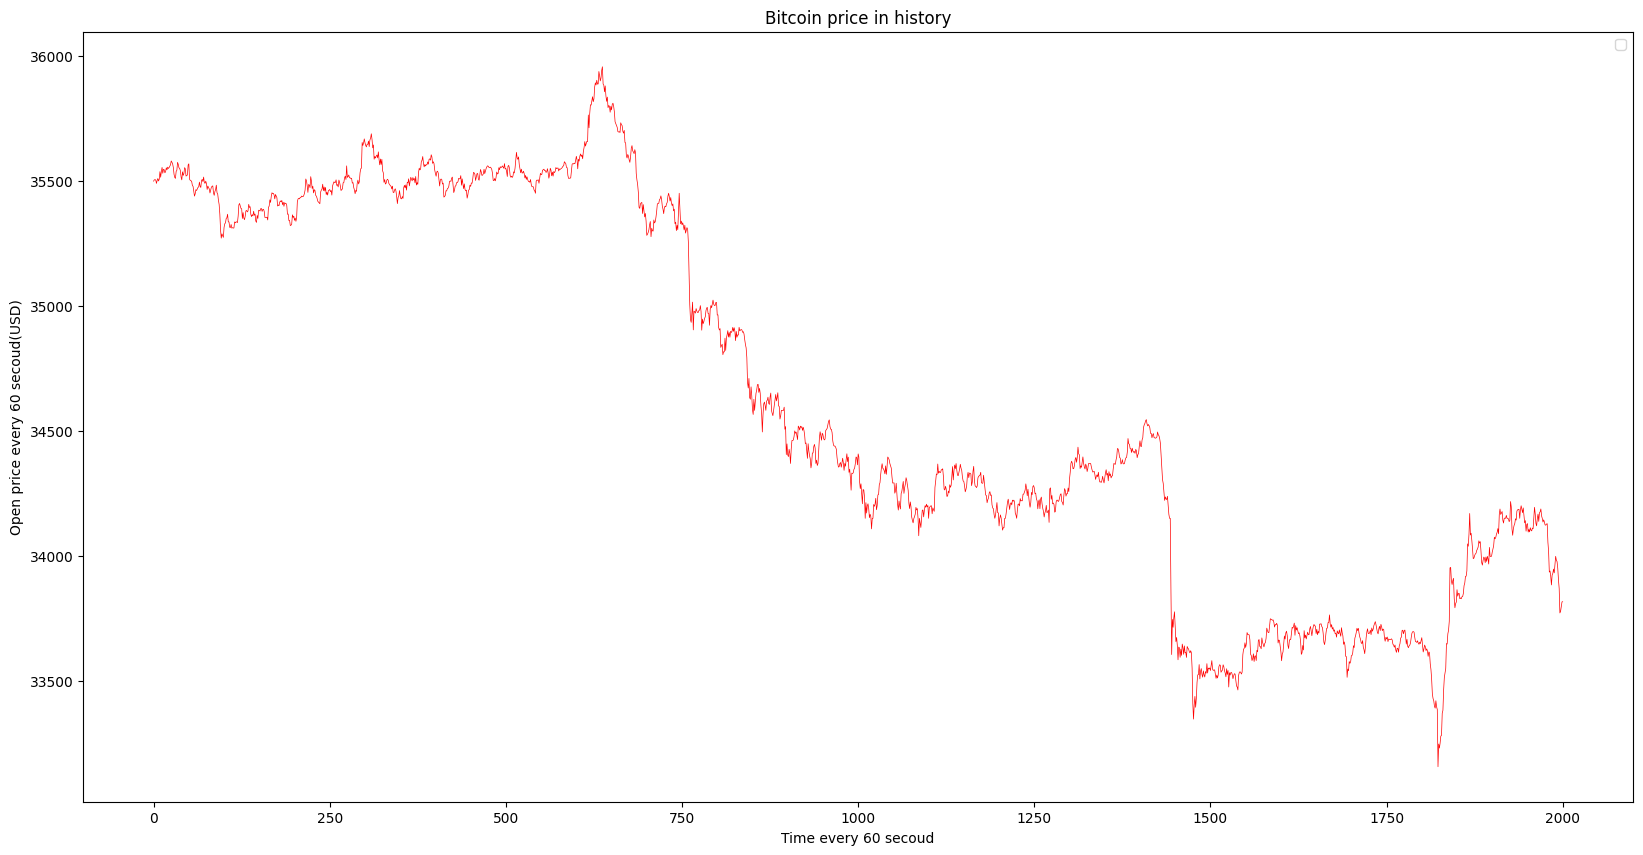

In [ ]:
plt.figure(figsize=(20,10))
plt.plot([x for x in range(df['Open'].shape[0])], df['Open'], color = 'red', linewidth = 0.5)
plt.title("Bitcoin price in history")
plt.xlabel("Time every 60 secoud")
plt.ylabel("Open price every 60 secoud(USD)")
plt.legend();

## 2. Replaybuffer:

This dict will contain all of agent given action in histroy.
which cause agent learning.

**NOTE that in this project agent isn't learning from the given data(bitcoin data). IS FROM THE REPLAYBUFFER. NOT GIVEN DATA**

each slot contain  
$s_t$,

$s_t+1$,

$r$,

$a$,

$done$
(wthever episode finished or not).

overall this is auto $\pi_t$($a_t$ | $s_t$)

In [ ]:
class Replaybuffer:
    def __init__(self, state_dim, action_size, size):
       self.obs_buf = np.zeros([size, state_dim], dtype=np.float32)
       self.obs2_buf = np.zeros([size, state_dim], dtype=np.float32)
       self.reward_buf = np.zeros(size, dtype = np.float32)
       self.action_buf = np.zeros(size, dtype = np.uint8)
       self.done_buf = np.zeros(size, dtype = np.uint8)
       self.max_size = size
       self.pointer, self.size = 0,0
    def store(self, obs, obs2, reward, action, done):
        self.obs_buf[self.pointer] = obs
        self.obs2_buf[self.pointer] = obs2
        self.reward_buf[self.pointer] = reward
        self.action_buf[self.pointer] = action
        self.done_buf[self.pointer] = done
        self.pointer = (self.pointer+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size = 32):
        idx = np.random.randint(0, self.size, size = batch_size)
        buffer = dict(s = self.obs_buf[idx],
            s2 = self.obs2_buf[idx],
            r = self.reward_buf[idx],
            a = self.action_buf[idx],
            done = self.done_buf[idx])
        print(buffer)
        return buffer

In [ ]:
def get_scaler(env):
    states = []
    for _ in range(env.n_step):
        action = [np.random.choice([0,1,2])]
        state, reward, done, info = env.step(action)
        states.append(state)
        if done: break
    scaler = StandardScaler()
    scaler = scaler.fit(states)
    return scaler

In [ ]:
def create_network(state_dim, action_dim, hidden_layer = 1, hidden_cell = 32):

    i = Input(shape = (state_dim,))
    x = i
    for _ in range(hidden_layer):
        x = Dense(hidden_cell, activation = "relu")(x)

    x = Dense(action_dim, activation = "softmax")(x)

    model = Model(i,x)

    model.compile(optimizer = "adam", loss = "mse")
    print(model.summary())
    return model

In [ ]:
class BitcoinEnv:
    def __init__(self, data, money_buy_each_time = 2000, investment_money = 20000, n_step = 200):
        self.bitcoin_in_history = data
        #n_step mean to agent will trade n_step/60 hours
        #1200 for exp n_step = 1200 / 60 = 20 hours
        self.n_step = n_step
        self.money_buy_each_time = money_buy_each_time

        self.cur_step = None
        self.investment_money = investment_money
        self.bitcoin_wallet = None
        self.bitcoin_price = None
        self.cur_cash = None

        #0 = sell, 1 = hold, 2 = buy
        self.action_space = [[0],[1],[2]]
        self.action_list = np.arange(3)

        #3 type of 1.currily Price, 2.Bitcoin wallet 3.Cash in hand
        self.state_dim = 3

        self.reset()

    def reset(self):
        self.n_step = 5000000 + 200
        self.cur_step = 5000000
        self.bitcoin_wallet = 0
        self.cur_cash = self.investment_money
        self.investment_money = self.investment_money
        self.bitcoin_price = self.bitcoin_in_history[self.cur_step]

        return self._get_obs()

    def step(self, action):
        assert action in self.action_list

        done = self.cur_step == self.n_step - 1

        prev_val = self._get_obs()

        self.cur_step += 1
        self.bitcoin_price = self.bitcoin_in_history[self.cur_step]

        self._trade(action)

        cur_val = self._get_val()

        reward = cur_val - prev_val

        info = {"cur_val": cur_val}

        return self._get_obs(), reward, done, info

    def _get_obs(self):
        obs = np.empty(self.state_dim)
        obs[0] = self.bitcoin_price
        obs[1] = self.bitcoin_wallet
        obs[2] = self.cur_cash

        return obs

    def _get_val(self):
        return self.bitcoin_wallet * (self.bitcoin_price) + self.cur_cash

    def _trade(self, action):

        action_vector = self.action_list[action]
        if action_vector == [1]: #hold
            return
        elif action_vector == [2]: #buy
            if self.money_buy_each_time <= self.cur_cash:
                self.bitcoin_wallet += self.money_buy_each_time / self.bitcoin_price
                self.cur_cash -= self.money_buy_each_time
        elif action_vector == [0]: #sell(sell all currently have)
            if self.bitcoin_wallet > 0:
                self.cur_cash += self.bitcoin_wallet * self.bitcoin_price
                self.bitcoin_wallet = 0

$y = r+ γ* max(a) $

In [ ]:
class DQNAgent(object):
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = Replaybuffer(state_size, action_size, size = 500)
    self.gamma = 0.95
    self.epsilon = 1.0
    self.epsilon_min = 0.01
    self.decay = 0.995
    self.model = create_network(state_size, action_size)

  def update_replay_memory(self, state, next_state, reward, action, done):
    self.memory.store(state, next_state, reward, action, done)


  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return np.random.choice(self.action_size)
    act_values = self.model.predict(state)
    return np.argmax(act_values[0])
  @tf.function

  def replay(self, batch_size=32):
    if self.memory.size < batch_size:
        return

    minibatch = self.memory.sample_batch(batch_size)
    states = minibatch['s']
    next_state = minibatch['s2']
    rewards = minibatch['r']
    actions = minibatch['a']
    done = minibatch['done']

    target = rewards + self.gamma * np.amax(self.model.predict(next_state, verbose = 0), axis = 1)

    target_full = self.model.predict(states, verbose=0)
    target_full[np.arange(batch_size), actions] = target

    self.model.train_on_batch(states, target_full)

    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
def play_one_episode(agent, env, is_tarin):

    state = env.reset()
    state = scaler.transform([state])
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        if is_tarin == "train":
            agent.update_replay_memory(state, next_state, reward[2], action, done)
            agent.replay(batch_size)
        state = next_state

    return info['cur_val']


In [ ]:
#config
model_name = 'dqn.weight.h5'
num_episodes = 3000 #let's go for 300 for testing result
batch_size = 32
initial_investment = 20000

#n_timesteps, open_price = (np.array([x for x in range(df.shape[0])]), df['Open'].values)

#n_train = n_timesteps.shape[0] // 2

#train_data = df['Open'][:n_train]
#test_data = df['Open'][n_train:]

In [ ]:
#For tarining set up
env = BitcoinEnv(df['Open'])
agent = DQNAgent(env.state_dim, len(env.action_space))
scaler = get_scaler(env)
portfolio_value = []

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 227 (908.00 B)

 Trainable params: 227 (908.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
for e in range(num_episodes):
    t0 = time.time()
    val = play_one_episode(agent, env, 'train')
    t1 = time.time()
    portfolio_value.append(val)
    print(f"Episode: {e + 1} / {num_episodes}, Info: {val}, It took {t1 - t0} seconds ")